In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.

import kagglehub
dataset_path = kagglehub.dataset_download('omkargurav/face-mask-dataset')

print("Path to dataset files:", dataset_path)


Path to dataset files: /kaggle/input/face-mask-dataset


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
from tensorflow.keras import layers, models
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
import io
import cv2
from google.colab import files
import matplotlib.pyplot as plt

In [3]:

base_path = dataset_path + '/data'
print(os.listdir(base_path))

['without_mask', 'with_mask']


In [4]:
####  CODE FOR DATA DIVISION Among Folders

import os
import shutil
from sklearn.model_selection import train_test_split

# Original folder
source_dir = base_path
classes = ["with_mask", "without_mask"]

# Output base folder
output_dir =  "split_data"
splits = ['train', 'val', 'test']
ratios = [0.7, 0.15, 0.15]

# Create split directories
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Split and copy
for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    all_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg'))]

    # Train, temp split
    train_files, temp_files = train_test_split(all_files, test_size=1 - ratios[0], random_state=42)

    # Validation and test split from temp
    val_size = ratios[1] / (ratios[1] + ratios[2])
    val_files, test_files = train_test_split(temp_files, test_size=1 - val_size, random_state=42)

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(output_dir, 'train', cls, f))
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(output_dir, 'val', cls, f))
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(output_dir, 'test', cls, f))



In [5]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

output_dir =  "split_data"
EPOCHS = 10

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_gen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_gen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5286 images belonging to 2 classes.
Found 1133 images belonging to 2 classes.
Found 1134 images belonging to 2 classes.


In [6]:
print(os.listdir(output_dir +"/train"))

['without_mask', 'with_mask']


In [7]:

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 94/166 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.7221 - loss: 0.5692

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.7590 - loss: 0.5131 - val_accuracy: 0.9020 - val_loss: 0.2240
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.8577 - loss: 0.3301 - val_accuracy: 0.8941 - val_loss: 0.2388
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 31s 187ms/step - accuracy: 0.8890 - loss: 0.2802 - val_accuracy: 0.9206 - val_loss: 0.1742
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step - accuracy: 0.9080 - loss: 0.2306 - val_accuracy: 0.9391 - val_loss: 0.1789
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9087 - loss: 0.2220 - val_accuracy: 0.9365 - val_loss: 0.1675
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9164 - loss: 0.2191 - val_accuracy: 0.9409 - val_loss: 0.1475
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step - accuracy: 0.9227 - loss: 0.2020 - val_accuracy: 0.9559 - val_loss: 0.1169
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.9253 - loss: 0.2032 - val

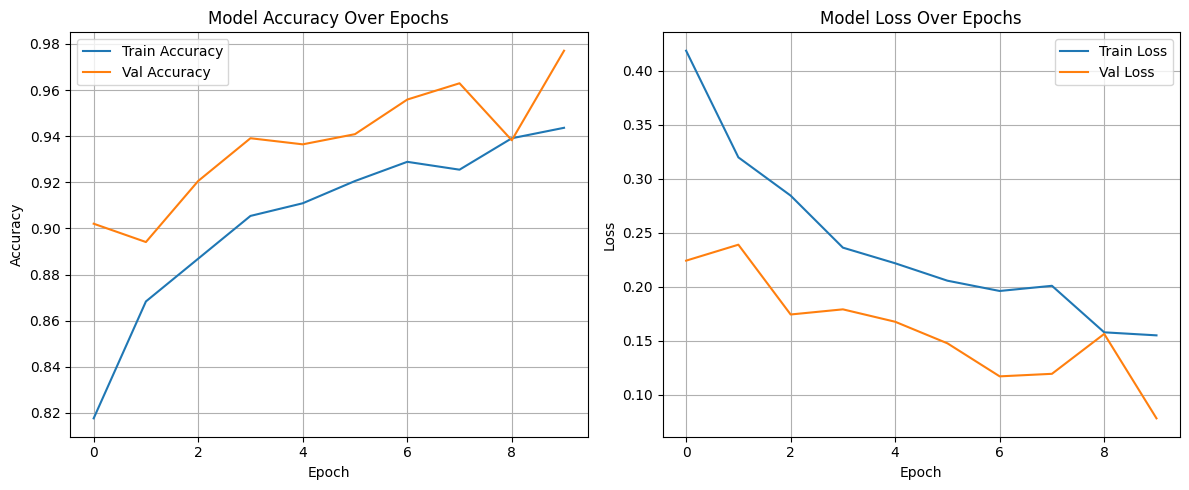

In [9]:

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
loss, accuracy = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {accuracy*100:.2f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9657 - loss: 0.1139

✅ Test Accuracy: 97.18


In [11]:
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Validation Accuracy: 97.71%


In [ ]:
# Save the trained model
model.save("mask_detection_model.h5")
print("Model saved to mask_detection_model.h5")

Model saved to mask_detection_model.h5


In [ ]:
# if model is fitted then no need to load model
model = tf.keras.models.load_model("mask_detection_model.h5")

IMG_SIZE = (128, 128)

# Define prediction function
def predict_mask_status(filename):
    try:

        # Read image from uploaded dict

        img = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize and normalize
        img_resized = cv2.resize(img_rgb, IMG_SIZE)
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=0)

        # Predict
        prediction = model.predict(img_input)[0][0]
        predicted_class = 'No_Mask' if prediction > 0.5 else 'Mask'
        confidence = prediction if prediction > 0.5 else 1 - prediction
        label_text = " "
        font = cv2.FONT_HERSHEY_SIMPLEX

        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        img_labeled =cv2.putText(img_bgr.copy(), label_text, (10, 20), font, 0.3, (0, 255, 0), 1, cv2.LINE_AA)

        # Show with matplotlib
        plt.imshow(cv2.cvtColor( img_labeled , cv2.COLOR_BGR2RGB))

        plt.axis('off')
        plt.title(f"Prediction: {predicted_class} , confidence : {confidence * 100:.2f}%")
        plt.show()

    except Exception as e:
        print(f"Error processing {filename}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


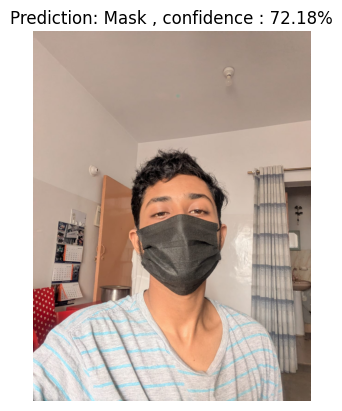

In [16]:
predict_mask_status("p1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


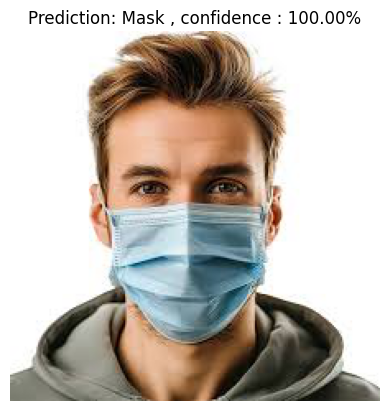

In [20]:
predict_mask_status("1.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


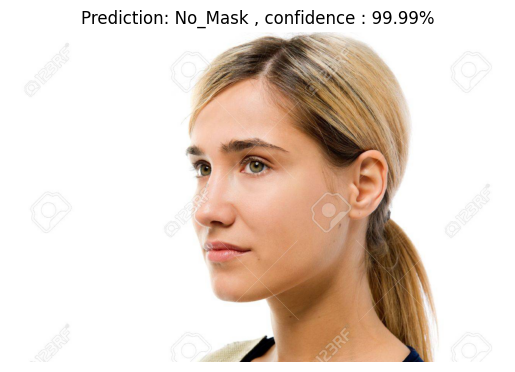

In [21]:
predict_mask_status("6.png")

In [18]:
uploaded = files.upload()

Saving 6.png to 6.png
Saving 1.png to 1.png
